# Create a simple linear regression model to predict the number of wins for an NFL team.

In [50]:
import pandas as pd

data = pd.read_csv("data/model_data.csv")
data.columns

Index(['year', 'wins', 'losses', 'win_loss_perc', 'points', 'points_opp',
       'points_diff', 'mov', 'g', 'total_yards', 'plays_offense',
       'yds_per_play_offense', 'turnovers', 'fumbles_lost', 'first_down',
       'pass_cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
       'pass_net_yds_per_att', 'pass_fd', 'rush_att', 'rush_yds', 'rush_td',
       'rush_yds_per_att', 'rush_fd', 'penalties', 'penalties_yds', 'pen_fd',
       'score_pct', 'turnover_pct', 'exp_pts_tot', 'ties', 'team_encoded'],
      dtype='object')

### Standardize and split the data.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

drop = [
    'wins', 'losses', 'win_loss_perc', 'ties'
]

x = data.drop(columns=drop)
y = data['wins']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

### Create a baseline model with no hyperparameter tuning.

In [52]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse

mse(y_test, y_pred)

1.5392843050244538

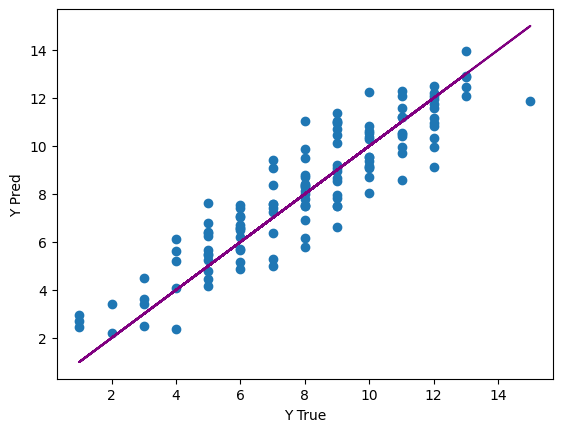

In [53]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Y True")
plt.ylabel("Y Pred")

plt.plot(y_test, y_test, color='purple')
plt.show()

### Clearly this model is not the best in terms of predicting wins. An average of 1.5 games off for a 16 or 17 game season is not a good enough performance.

## Hyperparameter Tuning

In [54]:
model.feature_names_in_

array(['year', 'points', 'points_opp', 'points_diff', 'mov', 'g',
       'total_yards', 'plays_offense', 'yds_per_play_offense',
       'turnovers', 'fumbles_lost', 'first_down', 'pass_cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'pass_net_yds_per_att',
       'pass_fd', 'rush_att', 'rush_yds', 'rush_td', 'rush_yds_per_att',
       'rush_fd', 'penalties', 'penalties_yds', 'pen_fd', 'score_pct',
       'turnover_pct', 'exp_pts_tot', 'team_encoded'], dtype=object)

['points' 'points_opp' 'points_diff' 'mov' 'total_yards' 'plays_offense'
 'yds_per_play_offense' 'turnovers' 'fumbles_lost' 'first_down' 'pass_cmp'
 'pass_yds' 'pass_td' 'pass_int' 'pass_net_yds_per_att' 'pass_fd'
 'rush_att' 'rush_yds' 'rush_td' 'rush_yds_per_att' 'rush_fd' 'penalties'
 'pen_fd' 'score_pct' 'turnover_pct' 'exp_pts_tot']


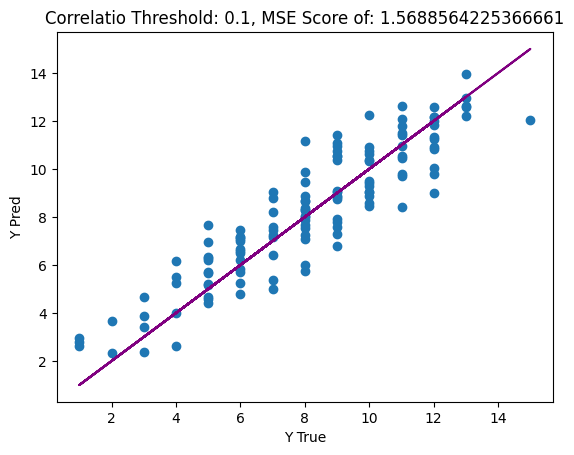

['points' 'points_opp' 'points_diff' 'mov' 'total_yards' 'plays_offense'
 'yds_per_play_offense' 'turnovers' 'fumbles_lost' 'first_down' 'pass_yds'
 'pass_td' 'pass_int' 'pass_net_yds_per_att' 'pass_fd' 'rush_att'
 'rush_yds' 'rush_td' 'rush_fd' 'score_pct' 'turnover_pct' 'exp_pts_tot']


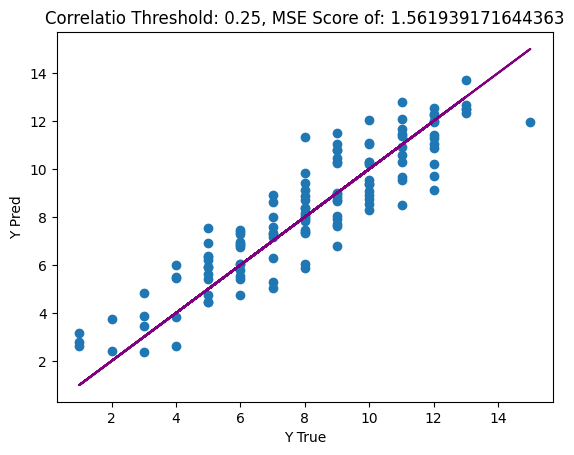

['points' 'points_opp' 'points_diff' 'mov' 'total_yards'
 'yds_per_play_offense' 'first_down' 'pass_td' 'pass_net_yds_per_att'
 'score_pct' 'turnover_pct' 'exp_pts_tot']


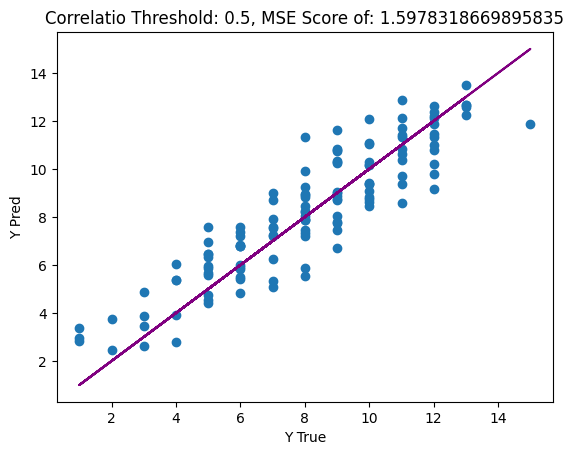

['points_diff' 'mov']


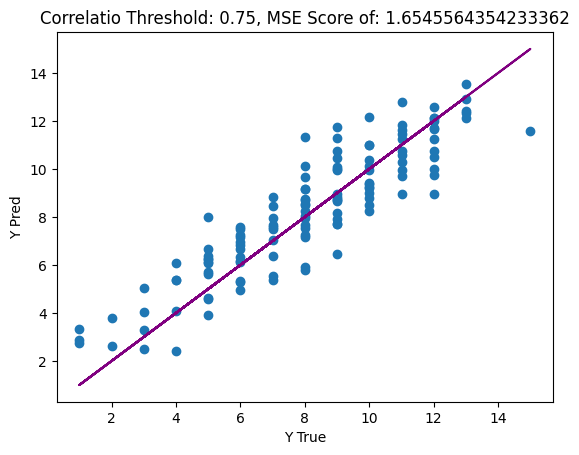

In [55]:
# Let's limit the number of features that we see to those only with a given threshold of correlation
corr = data.drop(columns=drop).corrwith(data['wins'])

scores = []

thresholds = [0.1, 0.25, 0.5, 0.75]
for thresh in thresholds:
    features = [feature for feature in corr.index if abs(corr[feature]) >= thresh]
    x = data.drop(columns=drop)[features]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(model.feature_names_in_)

    plt.scatter(y_test, y_pred)
    plt.xlabel("Y True")
    plt.ylabel("Y Pred")
    plt.title(f"Correlatio Threshold: {thresh}, MSE Score of: {mse(y_test, y_pred)}")

    plt.plot(y_test, y_test, color='purple')
    plt.show()


### While this model is not perfect, let's compare it to Vegas's win loss projection of each team for each season.

In [62]:
import requests
from bs4 import BeautifulSoup

vegas_data = []

for year in data['year'].unique():
        
    url = f'https://www.pro-football-reference.com/years/{year}/preseason_odds.htm'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table', {'id': 'preseason_odds'})

    headers = [th.text for th in table.find('tr').find_all('th')]
    headers.append('year')

    # Extract data
    for row in table.find_all('tr')[1:]:  # Skip header row
        my_row = []
        # Find the team name column
        team_name = row.find('a').text
        my_row.append(team_name)
        cols = row.find_all('td')
        if cols:  # Avoid empty rows
            my_row.extend([col.text for col in cols])
        my_row.append(year)
        vegas_data.append(my_row)

# Create DataFrame
vegas_df = pd.DataFrame(vegas_data, columns=headers)


In [65]:
vegas_df['wins'] = vegas_df['Record'].apply(lambda x: x.split('-')[0])
vegas_df

,Tm,Super Bowl Odds,W/L O-U,Record,year,wins
0,Arizona Cardinals,+30000,5.0,4-12 (under),2003,4
1,Atlanta Falcons,+1200,9.5,5-11 (under),2003,5
2,Baltimore Ravens,+3500,7.5,10-6 (over),2003,10
3,Buffalo Bills,+2000,8.5,6-10 (under),2003,6
4,Carolina Panthers,+6000,7.5,11-5 (over),2003,11
...,...,...,...,...,...,...
667,San Francisco 49ers,+1000,10.5,12-5 (over),2023,12
668,Seattle Seahawks,+3500,8.5,9-8 (over),2023,9
669,Tampa Bay Buccaneers,+10000,6.5,9-8 (over),2023,9
670,Tennessee Titans,+9000,7.5,6-11 (under),2023,6


In [73]:
import numpy as np

vegas_df['wins'] = pd.to_numeric(vegas_df['wins'], errors='coerce')
vegas_df['W/L O-U'] = pd.to_numeric(vegas_df['W/L O-U'], errors='coerce')

mse(vegas_df['wins'], vegas_df['W/L O-U'])

7.295758928571429

## Analysis

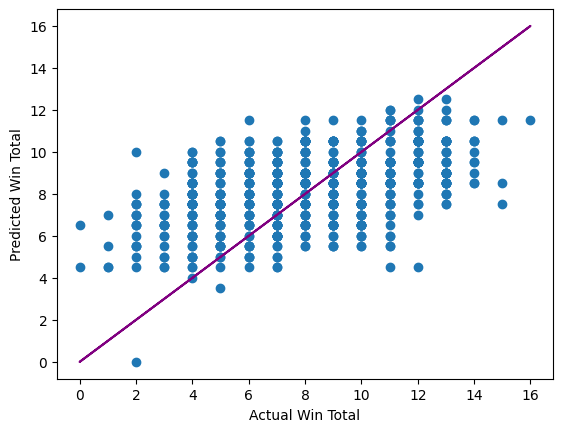

In [74]:
plt.scatter(vegas_df['wins'], vegas_df['W/L O-U'])
plt.xlabel("Actual Win Total")
plt.ylabel("Predicted Win Total")

plt.plot(vegas_df['wins'], vegas_df['wins'], color='purple')
plt.show()

Over the course of 20 seasons, Vegas is off on average about 7 games for an NFL team's project win totals. Our model is substantially better at predicting win totals for a season. However, the two models take into account two different sets of features. While it is unsure what Vegas uses to predict win totals, my current model uses data from the same season as the number of wins; therefore, the number of points scored in a season is used to predict the number of wins in the same season. This is not a realistic approach to creating a predictive model, as we will already have the number of wins for that given season. 

However, what if we were to use a previous season's data to predict an upcoming season?

In [94]:
# Update the data frame to contain the next year's win total for each team

next_season = data.copy()
next_season['year'] -= 1
next_season.rename(columns={'wins':'next_season_wins'}, inplace=True)
next_season = next_season[['team_encoded', 'year', 'next_season_wins']]

new_data = pd.merge(data, next_season, on=['team_encoded', 'year'], how='left')
# new_data[new_data['team_encoded'] == 21] # Test the data

,year,wins,losses,win_loss_perc,points,points_opp,points_diff,mov,g,total_yards,...,rush_fd,penalties,penalties_yds,pen_fd,score_pct,turnover_pct,exp_pts_tot,ties,team_encoded,next_season_wins
0,2003,14,2,0.875,348,238,110,6.9,16,5039,...,91,111,998,26,27.9,11.3,-136.51,0.0,21,14.0
31,2004,14,2,0.875,437,260,177,11.1,16,5722,...,120,101,822,31,42.1,14.6,22.20,0.0,21,10.0
62,2005,10,6,0.625,379,338,41,2.6,16,5632,...,101,110,921,29,34.8,13.0,-89.97,0.0,21,12.0
94,2006,12,4,0.750,385,237,148,9.3,16,5369,...,121,98,940,28,34.4,13.8,-76.38,0.0,21,16.0
124,2007,16,0,1.000,589,274,315,19.7,16,6580,...,124,78,690,26,52.7,7.8,133.73,0.0,21,11.0
156,2008,11,5,0.688,410,309,101,6.3,16,5847,...,145,57,501,25,44.8,11.5,-13.10,0.0,21,10.0
185,2009,10,6,0.625,427,285,142,8.9,16,6357,...,114,81,743,37,41.0,12.4,22.90,0.0,21,14.0
216,2010,14,2,0.875,518,313,205,12.8,16,5820,...,119,83,766,20,47.0,5.4,73.64,0.0,21,13.0
248,2011,13,3,0.813,513,342,171,10.7,16,6848,...,107,87,815,30,47.2,8.3,99.08,0.0,21,12.0
278,2012,12,4,0.750,557,331,226,14.1,16,6846,...,151,97,840,37,48.1,8.1,118.97,0.0,21,12.0


In [113]:
# Handle NA values created for new season win totals
# Teams switch names?

new_data.isna().sum()
print()
new_data[new_data['next_season_wins'].isna()]

# For now, I will just remove these rows
new_data = new_data[~new_data['next_season_wins'].isna()]

['wins' 'losses' 'win_loss_perc' 'points' 'points_opp' 'points_diff' 'mov'
 'g' 'total_yards' 'plays_offense' 'yds_per_play_offense' 'turnovers'
 'fumbles_lost' 'first_down' 'pass_cmp' 'pass_att' 'pass_yds' 'pass_td'
 'pass_int' 'pass_net_yds_per_att' 'pass_fd' 'rush_att' 'rush_yds'
 'rush_td' 'rush_yds_per_att' 'rush_fd' 'penalties' 'penalties_yds'
 'pen_fd' 'score_pct' 'turnover_pct' 'exp_pts_tot' 'ties' 'team_encoded']


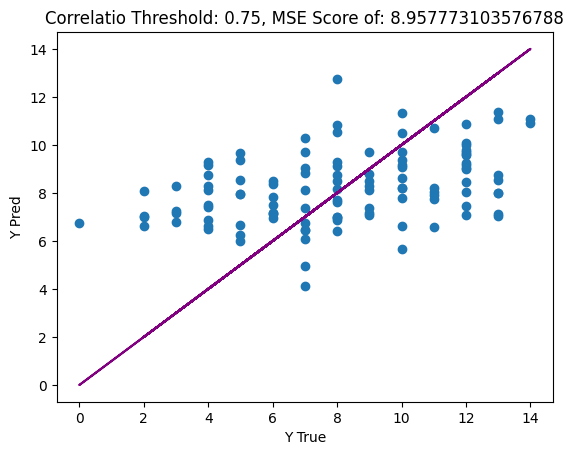

In [115]:
# I can now include the wins and losses as we are predicting the win totals for the next season
drop = [
    'year',
    'next_season_wins'
    # 'wins',
    # 'losses',

]

x = new_data.drop(columns=drop)
y = new_data['next_season_wins']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.feature_names_in_)

plt.scatter(y_test, y_pred)
plt.xlabel("Y True")
plt.ylabel("Y Pred")
plt.title(f"Correlatio Threshold: {thresh}, MSE Score of: {mse(y_test, y_pred)}")

plt.plot(y_test, y_test, color='purple')
plt.show()

## Final Analysis

The model I created performs worse than the model that Vegas uses. My first attempt at a model has a MSE of 8.96, while the Vegas model has a MSE of 7.30. There are several other factors to consider when predicting teams' success in the next season that I did not train the model on, such as the gain or loss of personnel and players, division opponents getting better, and draft picks.